<a href="https://www.kaggle.com/code/princesgs77/license-plate-detection-2?scriptVersionId=297168379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!python --version

In [ ]:
import sys
print(sys.version)



In [ ]:
!git clone https://github.com/Arijit1080/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR.git

In [1]:
cd Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR

/kaggle/working/Licence-Plate-Detection-and-Recognition-using-YOLO-V8-EasyOCR


In [ ]:
%%bash

cat > requirements.txt << 'EOF'
# Base ----------------------------------------
ultralytics==8.0.3
hydra-core==1.3.2
matplotlib==3.7.2
numpy==1.23.5
opencv-python==4.8.0.76
Pillow==9.5.0
PyYAML==6.0.1
requests==2.31.0
scipy==1.10.1
torch==2.0.1
torchvision==0.15.2
tqdm==4.66.1

# Logging -------------------------------------
tensorboard==2.13.0

# Plotting ------------------------------------
pandas==1.5.3
seaborn==0.12.2

# Extras --------------------------------------
ipython==8.12.3
psutil==5.9.8
thop==0.1.1.post2209072238

# HUB -----------------------------------------
GitPython==3.1.37
EOF

echo "====== requirements.txt created ======"
cat requirements.txt


In [ ]:
%pip install -r requirements.txt


In [ ]:
!rm -rf ultralytics

**Restart Kerne# l**

In [2]:
# Ultralytics YOLO 🚀, GPL-3.0 license

# import hydra
import re
import torch
import easyocr
import cv2
from ultralytics.yolo.engine.predictor import BasePredictor
from ultralytics.yolo.utils import DEFAULT_CONFIG, ROOT, ops
from ultralytics.yolo.utils.checks import check_imgsz
from ultralytics.yolo.utils.plotting import Annotator, colors, save_one_box

import matplotlib.pyplot as plt

def show(title, img, gray=False):
    plt.figure(figsize=(4,4))
    plt.title(title)
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()


def getOCR(im, coors):
    x1, y1, x2, y2 = map(int, coors)

    # Crop
    crop = im[y1:y2, x1:x2]

    show("Cropped Box", crop)

    # Gray
    gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)

    show("Gray for OCR", gray, gray=True)

    results = reader.readtext(gray)

    ocr = ""
    conf = 0.5

    for (bbox, text, score) in results:
        # if score > conf:
        ocr = ocr + text 

    # print("OCR Result:", ocr)
   


    
    

    def clean_text(text):
        text = text.upper()
        text = re.sub(r'[^A-Z0-9]', '', text)   # remove dots, spaces, symbols
        text = text.replace("IND", "")          # remove country tag
        return text
    def extract_plate(text):
        pattern = r'[A-Z]{2}[0-9]{2}[A-Z]{1,2}[0-9]{3,4}'
        match = re.search(pattern, text)
        return match.group(0) if match else None
    def format_plate(raw_text):
        text = clean_text(raw_text)
        plate = extract_plate(text)
        return plate
    
    
    print("👉👉👉Result:", format_plate(ocr))

    return str(ocr)



In [3]:
class DetectionPredictor(BasePredictor):

    def get_annotator(self, img):
        show("Original Image", img)
        return Annotator(img, line_width=self.args.line_thickness, example=str(self.model.names))


    def preprocess(self, img):
        img = torch.from_numpy(img).to(self.model.device)
        img = img.half() if self.model.fp16 else img.float()  # uint8 to fp16/32
        img /= 255  # 0 - 255 to 0.0 - 1.0
        return img 
    

    def postprocess(self, preds, img, orig_img):
        preds = ops.non_max_suppression(preds,
                                        self.args.conf,
                                        self.args.iou,
                                        agnostic=self.args.agnostic_nms,
                                        max_det=self.args.max_det)

        for i, pred in enumerate(preds):
            shape = orig_img[i].shape if self.webcam else orig_img.shape
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], shape).round()

        return preds

    def write_results(self, idx, preds, batch):
        p, im, im0 = batch
        log_string = ""
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        self.seen += 1
        im0 = im0.copy()
        if self.webcam:  # batch_size >= 1
            log_string += f'{idx}: '
            frame = self.dataset.count
        else:
            frame = getattr(self.dataset, 'frame', 0)

        self.data_path = p
        # save_path = str(self.save_dir / p.name)  # im.jpg
        self.txt_path = str(self.save_dir / 'labels' / p.stem) + ('' if self.dataset.mode == 'image' else f'_{frame}')
        log_string += '%gx%g ' % im.shape[2:]  # print string
        self.annotator = self.get_annotator(im0)

        det = preds[idx]
        self.all_outputs.append(det)
        if len(det) == 0:
            return log_string
        for c in det[:, 5].unique():
            n = (det[:, 5] == c).sum()  # detections per class
            log_string += f"{n} {self.model.names[int(c)]}{'s' * (n > 1)}, "
        # write
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        for *xyxy, conf, cls in reversed(det):
            if self.args.save_txt:  # Write to file
                xywh = (ops.xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                line = (cls, *xywh, conf) if self.args.save_conf else (cls, *xywh)  # label format
                with open(f'{self.txt_path}.txt', 'a') as f:
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')

            if self.args.save or self.args.save_crop or self.args.show:  # Add bbox to image
                c = int(cls)  # integer class
                label = None if self.args.hide_labels else (
                    self.model.names[c] if self.args.hide_conf else f'{self.model.names[c]} {conf:.2f}')
                ocr = getOCR(im0,xyxy)
                if ocr != "":
                    label = ocr
                self.annotator.box_label(xyxy, label, color=colors(c, True))
            if self.args.save_crop:
                imc = im0.copy()
                save_one_box(xyxy,
                             imc,
                             file=self.save_dir / 'crops' / self.model.model.names[c] / f'{self.data_path.stem}.jpg',
                             BGR=True)

        return log_string

Ultralytics YOLOv8.0.3 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14913MiB)
Fusing layers... 
Model summary: 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
WARNING ⚠️ --img-size [1200, 1200] must be multiple of max stride 32, updating to [1216, 1216]


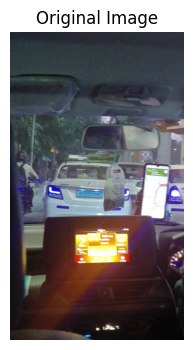

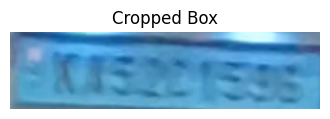

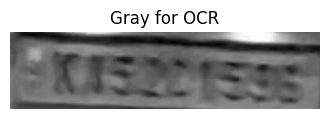

video 1/1 (1/276) /kaggle/input/cabs-vids/video_20260210_183118.mp4: 1216x704 1 LicensePlate, 55.1ms


👉👉👉Result: None


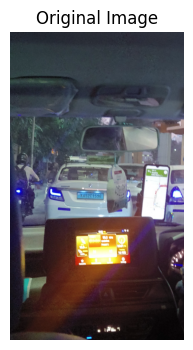

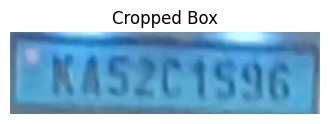

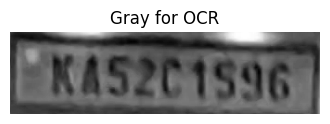

video 1/1 (2/276) /kaggle/input/cabs-vids/video_20260210_183118.mp4: 1216x704 1 LicensePlate, 12.4ms


👉👉👉Result: None


KeyboardInterrupt: 

In [4]:
# from ultralytics.yolo.cfg import get_cfg

def predict():

    overrides = {
        "model": "best.pt",
        "source": "/kaggle/input/cabs-vids/video_20260210_183118.mp4",
        "imgsz": (1200, 1200),   # ⭐ FIX HERE
        "conf": 0.1,
        "iou": 0.7,
        "max_det": 1000,
        "device": 0 if torch.cuda.is_available() else "cpu",
        "save": True,
        "show": False,
        "save_txt": False,
        "save_conf": False,
        "save_crop": False,
        "hide_labels": False,
        "hide_conf": False,
        "agnostic_nms": False,
        "line_thickness": 2
    }

    predictor = DetectionPredictor(DEFAULT_CONFIG, overrides)
    predictor()





if __name__ == "__main__":
    import sys
    sys.argv = [sys.argv[0]]   # 🔥 fix hydra + kaggle

    reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

    predict()
